# Jnkepler OMC Fitting

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import norm
import matplotlib

import jax.numpy as jnp
from jax import config, random
import numpyro, jax
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu') 
num_chains = 4
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

from jnkepler.jaxttv import JaxTTV
from jnkepler.jaxttv import ttv_default_parameter_bounds, ttv_optim_curve_fit, scale_pdic
import corner

# jax device count: 4


In [37]:
### switch for including new TESS times
exclude_TESS = True

In [45]:
### Read results
d = pd.read_csv("ttv_results.txt", sep="\s+", header=0, names=['Planet_num', 'Index', 'Tc', 'Tc_err', 'Source', 'Instrument'])


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_12461/3700620070.py:2: SyntaxWarning: invalid escape sequence '\s'
  d = pd.read_csv("ttv_results.txt", sep="\s+", header=0, names=['Planet_num', 'Index', 'Tc', 'Tc_err', 'Source', 'Instrument'])


In [46]:
if exclude_TESS ==True:
    filtered_d = d[d['Source'] != 'TESS']
    d = filtered_d


In [47]:
### get times, errs from the data
list_of_obs_transit_times = []
list_of_transit_time_errs = []
# period_guess = [7.9222, 11.8993] # rough initial guess to track transit epochs (from Petigura 2020)
period_guess = [7.91975198, 11.90285385]
for j in range(2):
    list_of_obs_transit_times.append(np.array(d.Tc[d.Planet_num==j+1]))
    list_of_transit_time_errs.append(np.array(d.Tc_err[d.Planet_num==j+1]))
index_obs_b = np.array(d.Index[d.Planet_num==1])
index_obs_c = np.array(d.Index[d.Planet_num==2])

tcobs = []
errorobs = []
for j in range(2):
    tcobs.append(np.array(d.Tc[d.Planet_num == j + 1]))
    errorobs.append(np.array(d.Tc_err[d.Planet_num == j + 1]))

In [48]:
### run JaxTTV sim
t_start = 1980.  # start of integration
# t_end = 5500. # end of integration
t_end = 5500.
dt = 0.25 # integration timestep
# jttv = JaxTTV(t_start, t_end, dt, list_of_obs_transit_times, period_guess, errorobs=list_of_transit_time_errs)
jttv = JaxTTV(t_start, t_end, dt, tcobs, period_guess, errorobs=errorobs, print_info=True)

# number of transiting planets:    2
# integration starts at:           1980.00
# first transit time in data:      1980.38
# last transit time in data:       3197.86
# integration ends at:             5500.00
# integration time step:           0.2500 (1/31 of innermost period)



In [49]:
### set bounds for fit
param_bounds = ttv_default_parameter_bounds(jttv, emax=0.25)

### initialize p_init: p1,p2,ecosw1,ecosw2,esinw1,esinw2,tic1,tic2,lnpmass1,lnpmass2
### using best fit for run with all points
p_init = np.array([7.91978264, 11.90381532, -0.12693783, -0.08689699, -0.14793586, -0.17598388, 1980.38363425, 1984.27272612, -9.07538167, -10.13796006])

### fit
popt = ttv_optim_curve_fit(jttv,param_bounds,p_init=p_init, plot=False)
# plt.show()
print(popt)

# running least squares optimization...


/opt/homebrew/anaconda3/lib/python3.12/site-packages/jnkepler/jaxttv/infer.py:97: UserWarning: Bounds for cosi/lnode not provided: assuming coplanar orbits.
  warnings.warn(


# objective function: 43.15 --> 41.99 (25 data)
# elapsed time: 4.4 sec
{'period': array([ 7.92008659, 11.9019615 ]), 'ecosw': array([-0.13224996, -0.09183343]), 'esinw': array([-0.22891104, -0.24999999]), 'tic': array([1980.38358348, 1984.27249138]), 'lnpmass': array([ -8.96002475, -10.018522  ]), 'pmass': Array([1.28443074e-04, 4.45667720e-05], dtype=float64)}


/opt/homebrew/anaconda3/lib/python3.12/site-packages/jnkepler/jaxttv/jaxttv.py:523: UserWarning: using t0 and P from a linear fit to the observed transit times.
  warnings.warn(


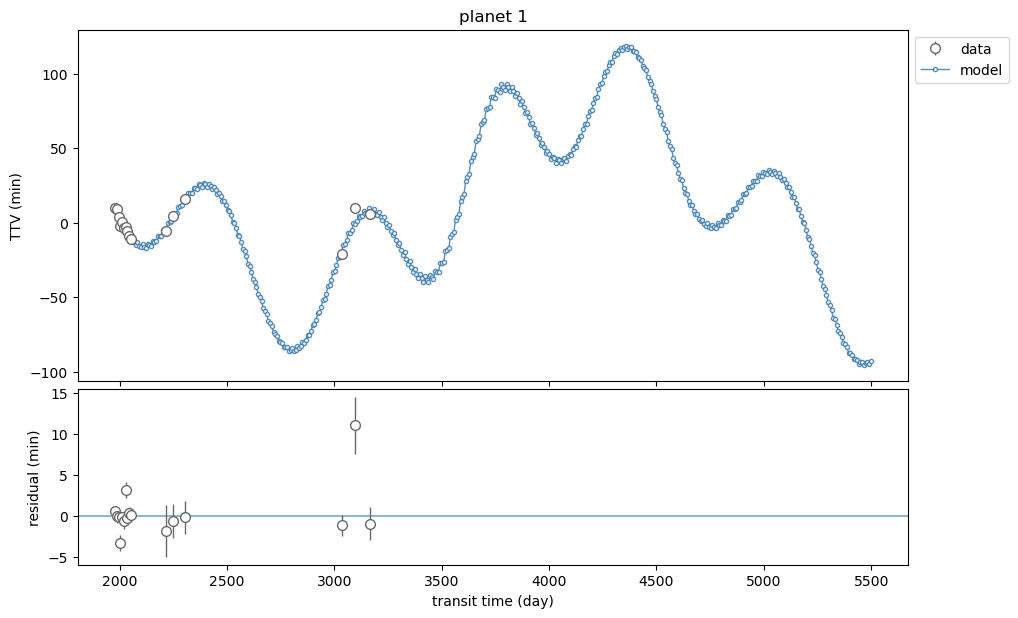

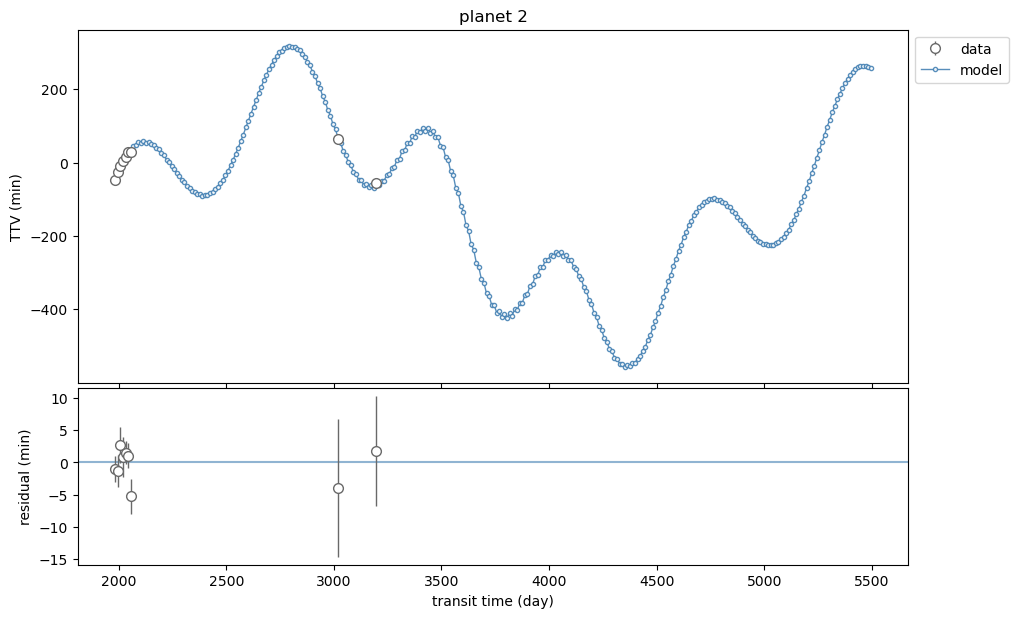

In [50]:
### plot fit
tcall = jttv.get_transit_times_all_list(popt,truncate=False)
jttv.plot_model(tcall, marker='.')
plt.show()

# fractional energy error (symplectic, dt=2.50e-01): -1.61e-08
# fractional energy error (symplectic, dt=7.92e-03): 1.84e-11
# max difference in tc: 1.00e-05 days (0.87 sec)


sample: 100%|█| 1000/1000 [00:00<00:00, 2074.12it/s, 3 steps of size 4.66e-01. a



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      lndf      0.74      0.64      0.61     -0.12      1.68    109.50      1.01
     lnvar     -0.90      0.58     -0.92     -1.83      0.02    152.19      1.01

Number of divergences: 0


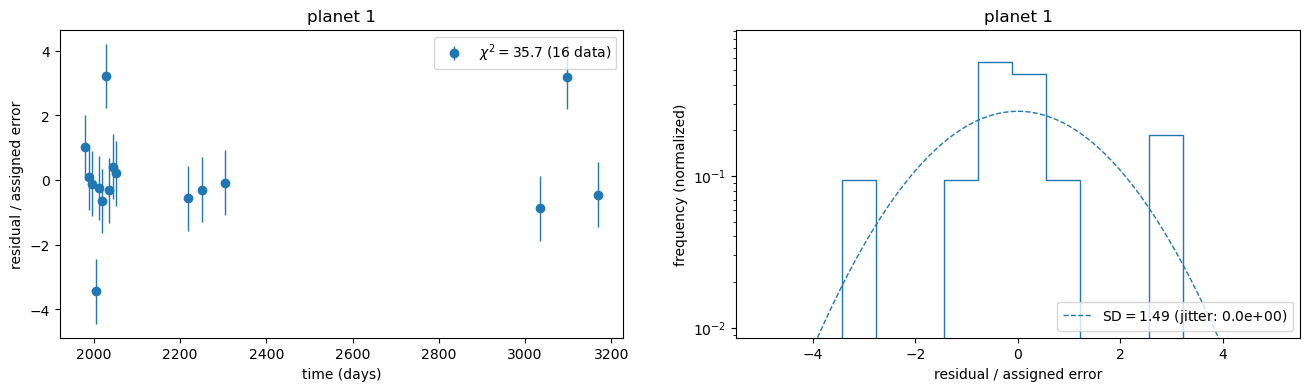

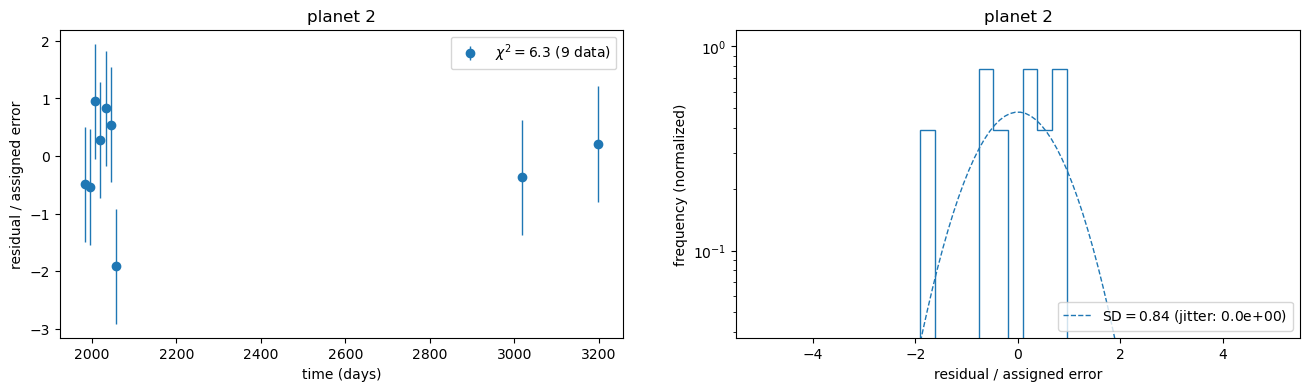

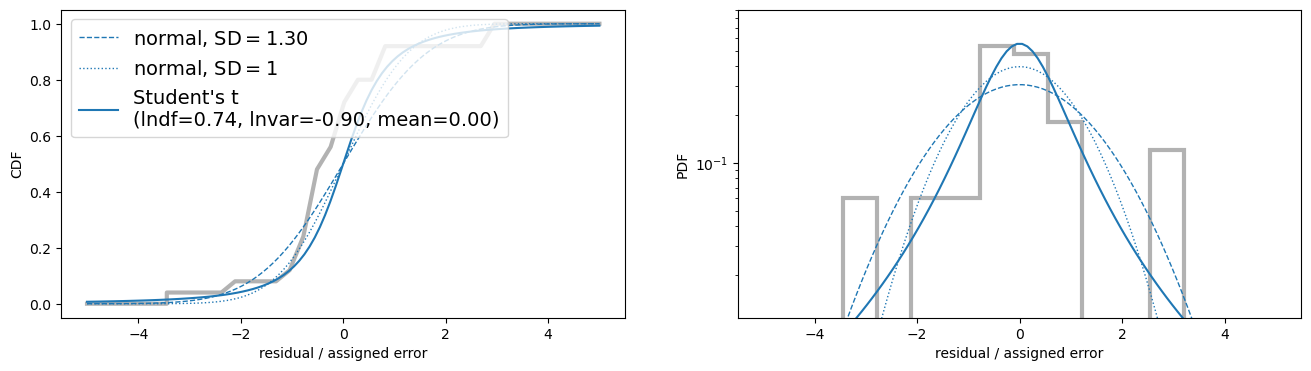

In [51]:
### check precision and residuals 
tc, _ = jttv.check_timing_precision(popt)

pdic_normal, pdic_student = jttv.check_residuals(popt)
plt.show()

### Save results

In [52]:
### save data
### jnkep model times
t_jnkep_b = tcall[0]
t_jnkep_c = tcall[1]

### jnkep obs times
t_obs_b = tcobs[0]
t_obs_c = tcobs[1]

### best fit params 
best_fit_period_b = popt['period'][0]
best_fit_period_c = popt['period'][1]
best_fit_tc_b = popt['tic'][0]
best_fit_tc_c = popt['tic'][1]

In [53]:
import json

# Convert all arrays to regular lists
fit_data = {
    "jnkep_model_times": {
        "b": tcall[0].tolist(),
        "c": tcall[1].tolist()
    },
    "jnkep_observed_times": {
        "b": tcobs[0].tolist(),
        "c": tcobs[1].tolist()
    },
    "jnkep_observed_index": {
        "b": index_obs_b.tolist(),
        "c": index_obs_c.tolist()
    },
    "best_fit_params": {
        "period": {
            "b": float(popt['period'][0]),
            "c": float(popt['period'][1])
        },
        "tc": {
            "b": float(popt['tic'][0]),
            "c": float(popt['tic'][1])
        }
    }
}

# Save to JSON
with open("jnkep_fit_data.json", "w") as f:
    json.dump(fit_data, f, indent=4)

print("Data saved successfully.")

Data saved successfully.


In [54]:
### save popt and param_bounds for the mcmc
import pickle
print(popt)
print(param_bounds)
with open('jnkep_initial_fit_data.pkl', 'wb') as f:
    pickle.dump({'jttv': jttv, 'popt': popt, 'param_bounds': param_bounds}, f)

{'period': array([ 7.92008659, 11.9019615 ]), 'ecosw': array([-0.13224996, -0.09183343]), 'esinw': array([-0.22891104, -0.24999999]), 'tic': array([1980.38358348, 1984.27249138]), 'lnpmass': array([ -8.96002475, -10.018522  ]), 'pmass': Array([1.28443074e-04, 4.45667720e-05], dtype=float64)}
{'tic': [array([1980.33403, 1984.22227]), array([1980.43403, 1984.32227])], 'period': [array([ 7.84055446, 11.78382531]), array([ 7.9989495 , 12.02188239])], 'ecosw': [array([-0.25, -0.25]), array([0.24, 0.24])], 'esinw': [array([-0.25, -0.25]), array([0.24, 0.24])], 'lnpmass': [array([-16.11809565, -16.11809565]), array([-6.90775528, -6.90775528])], 'pmass': [array([1.e-07, 1.e-07]), array([0.001, 0.001])]}
